In [1]:
#Catalunya_outline = gpd.read_file("/home/BTemple-Boyer-Dury/Documents/geopandas/Límits administratius provincials de Catalunya")
#Girona_outline = Catalunya_outline.loc[Catalunya_outline.loc[:,'nom_prov']=='Girona']

#departments_outline = gpd.read_file("/home/BTemple-Boyer-Dury/Documents/geopandas/departements-20220101-shp")
#options = list(departments_outline["nom"].unique())
#departments_outline

In [ ]:
#root path to be set

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.validation import explain_validity
from datetime import datetime
from collections import defaultdict

print('module needed downloaded')

def let_user_pick(options):
    my_list=[]
    print("Please choose:")

    for idx, element in enumerate(options):
        print("{}) {}".format(idx + 1, element))

    inp = input("Enter 2 numbers with a space between them: ")
    l = list(inp.split(" "))
    for n in l: 
        my_list.append(options[int(n) - 1])
    return my_list

def autopct(pct): # only show the label when it's > 10%
    return ('%.2f' % pct) if pct > 5 else ''

def create_keys(my_array):
    my_keys = defaultdict(list)
    for i in my_array: 
        my_keys[i[0:3]].append(i)
    doublons=[]
    for k,l in my_keys.items():
        if len(l) > 1:
            doublons.append(k)
        my_keys[k] = l[0]
    for k in doublons:
        del my_keys[k]
    return my_keys

print('functions created')

regions_outline = gpd.read_file("/home/BTemple-Boyer-Dury/Documents/Agrivolution/data/shp/Region2020/Region2020.shp")
Occitania_outline = regions_outline.loc[regions_outline.loc[:,'LbRegion'] == 'Occitanie']
Occitania_outline.to_crs(4326,inplace=True)

Occitania_crops = gpd.read_file("/home/BTemple-Boyer-Dury/Documents/Agrivolution/data/shp/RPG_2-0_SHP_LAMB93_R76_2020/PARCELLES_GRAPHIQUES.shp")
Occitania_crops.to_crs(4326,inplace=True)
print('Occitania_crops downloaded and crs converted')

departments_outline = gpd.read_file("/home/BTemple-Boyer-Dury/Documents/Agrivolution/data/shp/departements-20220101-shp")
departments_Occ_outline = gpd.sjoin(Occitania_outline, departments_outline, predicate='intersects')
dep_Occ = list(departments_Occ_outline["nom"].unique())
print('departments_outline downloaded and departments from Occitania selected into dep_Occ')

#Catalunya_crops_outline

Catalunya_crops = gpd.read_file("/home/BTemple-Boyer-Dury/Documents/Agrivolution/data/shp/Cultius_DUN2020_SHP")
Catalunya_crops.to_crs(4326, inplace=True)
print('Catalunya_crops downloaded and crs converted')

provincia_Cat_outline = gpd.read_file("/home/BTemple-Boyer-Dury/Documents/Agrivolution/data/shp/Límits administratius provincials de Catalunya")
prov_Cat = list(provincia_Cat_outline["nom_prov"].unique())

options = dep_Occ + prov_Cat

print('options possibilities initialized')

deps = let_user_pick(options)
#group_icc = pd.read_csv("/home/BTemple-Boyer-Dury/Documents/Classificrops/data/ICC/ICC_group.csv", encoding= 'unicode_escape')
#group_icc.set_index('ID', inplace = True)
#d_icc = group_icc.to_dict('dict')
#group_dict_icc = d_icc['label_en']

icc_df = pd.read_csv("/home/BTemple-Boyer-Dury/Documents/Classificrops/data/ICC/ICC_src.csv", encoding= 'unicode_escape')
icc_df['code'] = icc_df['code'].astype('str')

mask_0 = (icc_df['code'].str.len() == 1)
LEVEL_0 = icc_df.loc[mask_0]
LEVEL_0.drop(['broader'],axis=1,inplace=True)
LEVEL_0.set_index('code', inplace = True)
d_icc_0 = LEVEL_0.to_dict('dict')
group_dict_icc_0 = d_icc_0['label_en']

print("preparing the groups dict")

module needed downloaded
functions created


/home/BTemple-Boyer-Dury/miniconda3/envs/classificrops_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [11]:
list_resulting_gdf = []
for dep in deps:
    if dep in dep_Occ: 
        print("dep_Occ loading")
        selected_outline = departments_outline.loc[departments_outline.loc[:,'nom']==dep]
        #selected_outline = selected_outline.to_crs(4326)

        selected_crops = gpd.sjoin(Occitania_crops, selected_outline, predicate='intersects')
        print("jointure success")
        selected_crops.loc[:,'validity'] = selected_crops.loc[:,'geometry'].is_valid
        valid = selected_crops.loc[selected_crops.loc[:,'validity'] == True]
        invalid = selected_crops.loc[selected_crops.loc[:,'validity'] == False]
        corrected_df = invalid.copy()
        corrected_geometry = invalid.buffer(0)
        corrected_df['geometry'] = corrected_geometry
        selected_corrected = pd.concat([valid, corrected_df])
        selected_corrected.drop(['validity'],axis=1,inplace=True)
        print("geometries corrected")
        conversion_fr_icc = pd.read_csv("/home/BTemple-Boyer-Dury/Documents/Classificrops/data/FR/handmade_Nicolas_light.csv", encoding= 'unicode_escape')
        conversion_fr_icc['ID_GROUP_ICC'] = conversion_fr_icc['ICC1.1'].str[:1]
        conversion_fr_icc.drop(['ICC1.1'],axis=1, inplace=True)
        conversion_fr_icc.rename(columns = {'ID_CROPS_FR':'CODE_CULTU'}, inplace=True)
        print("conversion ICC table loaded")
        selected_icc_merged = selected_crops.merge(conversion_fr_icc, how='left', on='CODE_CULTU')
        #selected_icc_merged = selected_icc_merged_1['ID_GROUP_ICC_str'].loc[selected_icc_merged_1['ID_GROUP_ICC_str']!='#']
        surf_tot_crops = selected_crops["SURF_PARC"].sum()
        percentages_icc = {}

        for k,v in group_dict_icc_0.items(): 
            a = selected_icc_merged[selected_icc_merged['ID_GROUP_ICC']==str(k)]
            s = a["SURF_PARC"].sum()
            p = (s*100) / surf_tot_crops
            percentages_icc[v] = p
            
        issue = selected_icc_merged['ID_GROUP_ICC'].loc[selected_icc_merged['ID_GROUP_ICC']=='#']
        no_match = len(issue)*100/len(selected_icc_merged)
        percentages_icc['no_match'] = no_match
        df_icc_2 = pd.DataFrame.from_dict(percentages_icc,orient='index',columns=['per'])
        list_resulting_gdf.append(selected_icc_merged)
        #df_icc_2.plot.pie(y=0, figsize=(15, 15), autopct=autopct, title = dep+' with ICC classification')
        selected_icc_merged['place'] = dep
        #concatenate merged_gpd and selected_icc_merged
        print("dep_Occ selected sucessfully loaded")

    if dep in prov_Cat:
        print("dep_Cat loading")
        selected_crops = Catalunya_crops.loc[Catalunya_crops.loc[:,'Provincia']==dep]

        selected_crops = selected_crops[['Grup','Cultiu','HA','geometry']]
        
        conversion_cat_icc = pd.read_csv("/home/BTemple-Boyer-Dury/Documents/Classificrops/data/CAT/handmade_Nicolas_light.csv", encoding= 'unicode_escape')
        conversion_cat_icc['ID_GROUP_ICC'] = conversion_cat_icc['ICC1.1'].str[:1]
        conversion_cat_icc.drop(['ICC1.1'],axis=1, inplace=True)
        conversion_cat_icc.rename(columns = {'ID_CROPS_CAT':'Cultiu'}, inplace=True)
        print(conversion_cat_icc)
        print("conversion ICC table loaded")
        selected_crops['Cultiu'] = selected_crops['Cultiu'].str.lower()
        selected_icc_merged = selected_crops.merge(conversion_cat_icc, how='left', on='Cultiu')
        print(selected_icc_merged)
        #selected_icc_merged['ID_GROUP_ICC'] = selected_icc_merged['ID_GROUP_ICC_str'].apply(lambda x : int(x) if x not in ["#", np.nan] else x)
        surf_tot_selected = selected_crops["HA"].sum()
        percentages_icc = {}
        for k,v in group_dict_icc_0.items(): 
            a = selected_icc_merged[selected_icc_merged['ID_GROUP_ICC']==str(k)]
            s = a["HA"].sum()
            p = (s*100) / surf_tot_selected
            percentages_icc[v] = p

        issue = selected_icc_merged['ID_GROUP_ICC'].loc[selected_icc_merged['ID_GROUP_ICC']=='#']
        no_match = len(issue)*100/len(selected_icc_merged)
        percentages_icc['no_match'] = no_match
        print(percentages_icc)
        df_icc_3 = pd.DataFrame.from_dict(percentages_icc,orient='index',columns=['per'])
        #df_icc_3.plot.pie(y=0, figsize=(15, 15), autopct=autopct)
        Grups = selected_icc_merged['Grup'].unique()
        Cultius = selected_icc_merged['Cultiu'].unique()
        Grups_keys = create_keys(Grups)
        Cultius_keys = create_keys(Cultius)
        selected_icc_merged['CODE_GROUP'] = selected_icc_merged['Grup'].apply(lambda x : k if (x == v for k,v in Grups_keys) else x)
        selected_icc_merged['CODE_CULTU'] = selected_icc_merged['Cultiu'].apply(lambda x : k if (x == v for k,v in Cultius_keys) else x)
        selected_icc_merged.drop(['Grup','Cultiu'],axis=1,inplace=True)
        selected_icc_merged.rename(columns={'HA':'SURF_PARC'},inplace=True)
        list_resulting_gdf.append(selected_icc_merged)
        selected_icc_merged['place'] = dep
        print("dep_Cat selected sucessfully loaded")
        #concatenate merged_gpd and selected_icc_merged
concat_PO_Girona_ICC = pd.concat([df for df in list_resulting_gdf], ignore_index=True)
concat_PO_Girona_ICC.plot(cmap='jet', column = 'ID_GROUP_ICC', figsize=(15, 15),legend = True)

dep_Occ loading


KeyboardInterrupt: 

        code broader                           label_en
0          1     NaN                            Cereals
1       1.01       1                              Wheat
2       1.02       1                              Maize
3       1.03       1                               Rice
4       1.04       1                            Sorghum
..       ...     ...                                ...
191  9.05.02    9.05             Permanent flower crops
192     9.06       9                            Tobacco
193      9.9       9                Other crops, n.e.c.
194  9.90.01     9.9  Other crops, n.e.c. â temporary
195  9.90.02     9.9  Other crops, n.e.c. â permanent

[196 rows x 3 columns]
{'1.01': 'Wheat', '1.02': 'Maize', '1.03': 'Rice', '1.04': 'Sorghum', '1.05': 'Barley', '1.06': 'Rye', '1.07': 'Oats', '1.08': 'Millet', '1.09': 'Triticale', '1.1': 'Buckwheat', '1.11': 'Fonio', '1.12': 'Quinoa', '1.13': 'Canary seed', '1.14': 'Mixed cereals', '1.9': 'Other cereals, n.e.c.', '2.01': 'Le

/tmp/ipykernel_40864/4203158899.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LEVEL_0.drop(['broader'],axis=1,inplace=True)
/tmp/ipykernel_40864/4203158899.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LEVEL_1.drop(['broader'],axis=1,inplace=True)


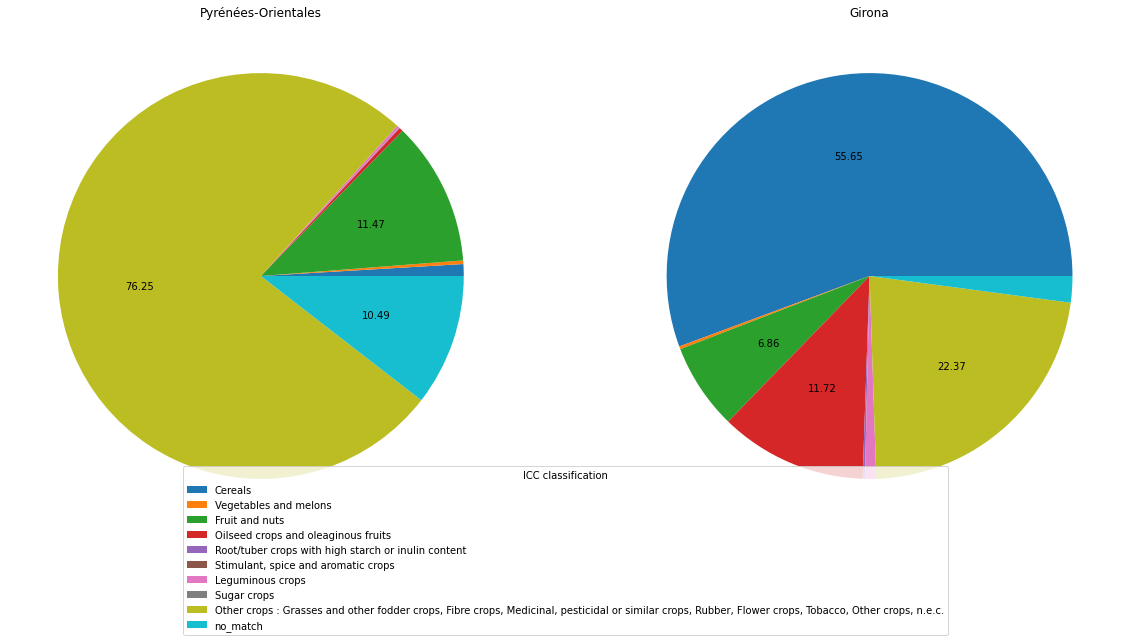

In [23]:
icc_df = pd.read_csv("/home/BTemple-Boyer-Dury/Documents/Classificrops/data/ICC/ICC_src.csv", encoding= 'unicode_escape')
icc_df['code'] = icc_df['code'].astype('str')
print(icc_df)
mask_0 = (icc_df['code'].str.len() == 1)
LEVEL_0 = icc_df.loc[mask_0]
LEVEL_0.drop(['broader'],axis=1,inplace=True)
LEVEL_0.set_index('code', inplace = True)
d_icc_0 = LEVEL_0.to_dict('dict')
group_dict_icc_0 = d_icc_0['label_en']
mask_1 = (icc_df['broader'].str.len() == 1)
LEVEL_1 = icc_df.loc[mask_1]
LEVEL_1.drop(['broader'],axis=1,inplace=True)
LEVEL_1.set_index('code', inplace = True)
d_icc_1 = LEVEL_1.to_dict('dict')
group_dict_icc_1 = d_icc_1['label_en']
print(group_dict_icc_1)
other_detailed = LEVEL_1.iloc[lambda x: x.index.str[:1] == '9']
string = ', '.join(other_detailed.label_en)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.pie(df_icc_2['per'], autopct=autopct) #plot first pie

ax2.pie(df_icc_3['per'], autopct=autopct) #plot second pie

ax1.set_title('Pyrénées-Orientales')
ax2.set_title('Girona')
#if df_icc_2.loc[ 'Other crops' ,'per'] > 10 or df_icc_3.loc[ 'Other crops' ,'per'] > 10:
#    df_icc_2.rename(index = lambda x: x + ' : ' + string if x == 'Other crops' else x, inplace=True)
fig.legend(df_icc_2.index, loc=8, title = "ICC classification")
#if df_icc_2['per']

In [70]:
surf_tot_Herault = Herault_crops["SURF_PARC"].sum()
percentages = {}
for k,v in group_dict.items(): 
    a = Herault_crops[Herault_crops['CODE_GROUP']==str(k)]
    s = a["SURF_PARC"].sum()
    p = (s*100) / surf_tot_Herault
    percentages[v] = p
percentages
per_Herault_2020_croplands = pd.DataFrame.from_dict(percentages,orient='index')
per_Herault_2020_croplands

'Grasses and other fodder crops, Fibre crops, Medicinal, pesticidal or similar crops, Rubber, Flower crops, Tobacco, Other crops, n.e.c.'

/tmp/ipykernel_40864/229380098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LEVEL_0.drop(['broader'],axis=1,inplace=True)
/tmp/ipykernel_40864/229380098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LEVEL_1.drop(['broader'],axis=1,inplace=True)


       ID_PARCEL  SURF_PARC CODE_CULTU CODE_GROUP CULTURE_D1 CULTURE_D2  \
0       13985177     0.3200        SNE         28       None       None   
1       13983543     0.7100        SNE         28       None       None   
2       11593485     1.1400        SPH         17       None       None   
3       11593484    96.1400        SPH         17       None       None   
4       14040527   332.3300        SPH         17       None       None   
...          ...        ...        ...        ...        ...        ...   
114447       NaN     0.9389          9          9        NaN        NaN   
114448       NaN     0.4970          9          9        NaN        NaN   
114449       NaN     0.7704          9          9        NaN        NaN   
114450       NaN     0.0873          9          9        NaN        NaN   
114451       NaN     0.0359          9          9        NaN        NaN   

                                                 geometry  index_right  \
0       POLYGON ((2.89920

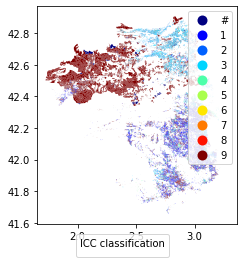

In [25]:
icc_df = pd.read_csv("/home/BTemple-Boyer-Dury/Documents/Classificrops/data/ICC/ICC_src.csv", encoding= 'unicode_escape')
icc_df['code'] = icc_df['code'].astype('str')

mask_0 = (icc_df['code'].str.len() == 1)
LEVEL_0 = icc_df.loc[mask_0]
LEVEL_0.drop(['broader'],axis=1,inplace=True)
LEVEL_0.set_index('code', inplace = True)
d_icc_0 = LEVEL_0.to_dict('dict')
group_dict_icc_0 = d_icc_0['label_en']

mask_1 = (icc_df['broader'].str.len() == 1)
LEVEL_1 = icc_df.loc[mask_1]
LEVEL_1.drop(['broader'],axis=1,inplace=True)
LEVEL_1.set_index('code', inplace = True)
d_icc_1 = LEVEL_1.to_dict('dict')
group_dict_icc_1 = d_icc_1['label_en']

other_detailed = LEVEL_1.iloc[lambda x: x.index.str[:1] == '9']
string = ', '.join(other_detailed.label_en)

#if df_icc_2.loc[ 'Other crops' ,'per'] > 10 or df_icc_3.loc[ 'Other crops' ,'per'] > 10:
#    df_icc_2.rename(index = lambda x: x + ' : ' + string if x == 'Other crops' else x, inplace=True)
fig, ax = plt.subplots()
concat_PO_Girona_ICC.plot(ax=ax, cmap='jet', column = 'ID_GROUP_ICC', figsize=(15, 15),legend = True)
print(concat_PO_Girona_ICC)
fig.legend(df_icc_2.index, loc=8, title = "ICC classification")


In [ ]:
concat_PO_Girona_ICC['GROUP_ICC'] = concat_PO_Girona_ICC['ID_GROUP_ICC'].apply(lambda x: )

In [ ]:
group_dict_icc_0